# Biomassters Data Exploration and Pre-Processing

1. Visualize Sentinel data and AGBM data 
2. Select best month of data for each chipid
3. Research Qs

### Download Data 

Download data with directions at https://www.drivendata.org/competitions/99/biomass-estimation/data/ 

Keep data in same directories for use with these notebooks

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import rasterio
from torchgeo.transforms import indices
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)  # our rasters are not georeferenced
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

### Import local modules

In [3]:
import dataloading as dl
import transforms as tf
import preprocessing as pp

### Set Device

In [18]:
if torch.backends.mps.is_available(): # Mac M1/M2
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'device: {device}')

device: mps


### Data directories

In [50]:
dir_tiles = '~/DATA/biomassters/tiles/train_features'
dir_target = '~/DATA/biomassters/tiles/train_agbm'
dir_test = '~/DATA/biomassters/tiles/test_features/'

### Transforms

In [6]:
transforms = nn.Sequential(
    indices.AppendNDVI(index_nir=6, index_red=2), # NDVI, index 15
    tf.AppendRatioAB(index_a=11, index_b=12),  # VV/VH Ascending, index 16
)

In [7]:
max_chips=None  # set how many data tiles to load; if tile_file=None then this limits tiles, not chips (multiple tiles per chipid)
dataset = dl.SentinelDataset(tile_file=None,
                             dir_tiles=dir_tiles,
                             dir_target=dir_target,
                             max_chips=max_chips,
                             transform=transforms,
                             device=device
                             )

## DataViz 

In [9]:
channel_map = {
    0: 'S2-B2: Blue-10m',
    1: 'S2-B3: Green-10m',
    2: 'S2-B4: Red-10m',
    3: 'S2-B5: VegRed-704nm-20m',
    4: 'S2-B6: VegRed-740nm-20m',
    5: 'S2-B7: VegRed-780nm-20m',
    6: 'S2-B8: NIR-833nm-10m',
    7: 'S2-B8A: NarrowNIR-864nm-20m',
    8: 'S2-B11: SWIR-1610nm-20m',
    9: 'S2-B12: SWIR-2200nm-20m',
    10: 'S2-CLP: CloudProb-160m',
    11: 'S1-VV-Asc: Cband-10m',
    12: 'S1-VH-Asc: Cband-10m',
    13: 'S1-VV-Desc: Cband-10m',
    14: 'S1-VH-Desc: Cband-10m',
    15: 'S2-NDVI: (NIR-Red)/(NIR+Red) 10m',
    16: 'S1-VV/VH-Asc: Cband-10m'
}
month_map = {
    0: 'Sep', 1: 'Oct', 2: 'Nov', 3: 'Dec',
    4: 'Jan', 5: 'Feb', 6: 'Mar', 7: 'Apr',
    8: 'May', 9: 'Jun', 10: 'Jul', 11: 'Aug'
}

In [11]:
def plot_by_tile_index(dataset, tile_idx, plot_channels, channel_map):
    sample = dataset[tile_idx]
    chipid, month_id = dataset.df_tile_list.iloc[tile_idx].values
    tile_name = f'Chip {chipid} {month_map[month_id]}'
    
    pp.plot_bands(tile=sample['image'].detach().cpu(),
               target=sample['label'].detach().cpu(),
               tile_name=tile_name,
               plot_channels=plot_channels,
               channel_map=channel_map
              )

### Specify which channels to plot

In [1]:
plot_channels = {
    0: {'s2_rgb_idxs': [2, 1, 0], 'title': 'RGB'}, # RGB image, special case 
    1: {'data': 'target', 'title': 'AGBM', 'LogNorm': True}, # AGBM target data, special case 
    2: {'channel_idx': 6},  # general case of visualizing by channel_index 
    3: {'channel_idx': 15},
    4: {'channel_idx': 10},
    5: {'channel_idx': 12}, 
    6: {'channel_idx': 16},
    7: {'s1_rgb_idxs': [11, 12, 16], 'title': 'SAR-RGB: VV,VH,VV/VH'}, # SAR psuedo-RGB, special case 
}

### Plot RGB, AGBM, and channels by tile index 

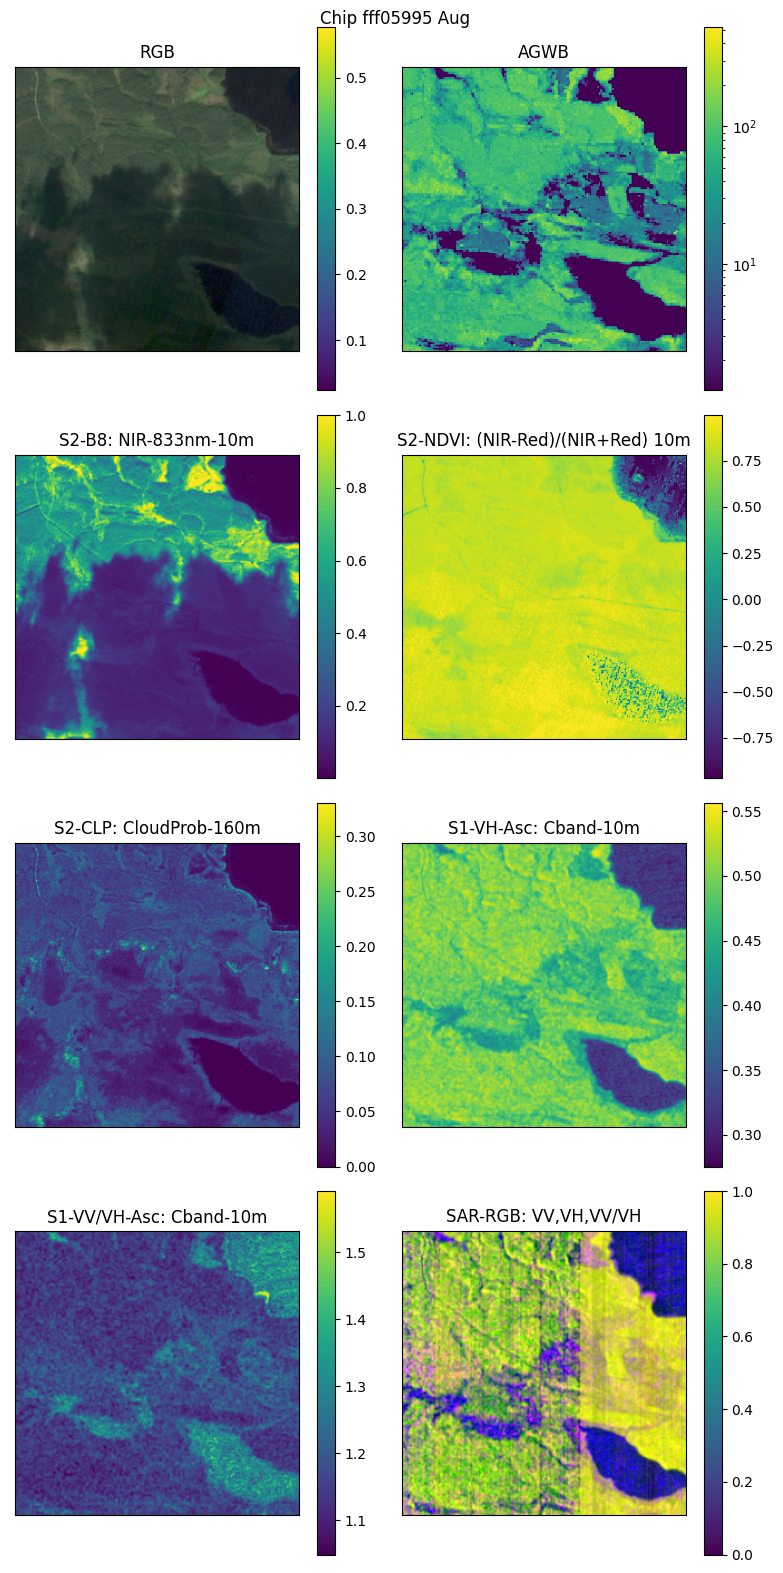

In [39]:
tile_idx = 104267 
plot_by_tile_index(dataset, tile_idx, plot_channels, channel_map)

## Select Best Month of Data for each ChipID
The Sentinel data is pretty messy, even with the curation provided by the Biomassters competition, so here we select a single month of data to be used for model training and prediction for each ChipID.

The Sentinel-1 SAR data is much more consitent than the Sentinel-2 optical data, so the basic approach is to use the SAR data as gold standard and choose months when the optical data most closely matches it. Specifically, we compare standardized data from of the NDVI index (clamped at 0 min) with the VH channel. The implementation here is heuristic and quick and can surely be improved upon, but the results are pretty reasonable. 

A further consideration is that not all months contain the same amount of information about AGBM. Sentinel data fron spring months, after snowmelt, tend to have the strongest correlation with AGBM, and so this is taken into account with a heuristic selection function. 

In [13]:
def diff_ndvi_sar_vh(tile, ndvi_idx, vh_idx):
    ndvi = minmax_scale(tile[ndvi_idx].clamp(0))
    vh = minmax_scale(tile[vh_idx])
    return ndvi - vh

In [14]:
def calc_frac_over_thresh(img, thresh=0.5):
    total_vals = 256*256.
    count_bad = img[np.abs(img)>thresh].shape[0]
    count_bad += np.isnan(img).sum()
    return round((count_bad)/total_vals, 3)

In [15]:
def calc_quality_scores(dataset):
    scores = []
    for ix, sample in tqdm(enumerate(dataset), total=len(dataset)):
        chipid, month_idx = dataset.df_tile_list.iloc[ix].values
        tile = sample['image'].detach().clone().cpu()
        diff_img = diff_ndvi_sar_vh(tile, ndvi_idx=15, vh_idx=12)
        score = 1 - calc_frac_over_thresh(diff_img, thresh=0.5)
        scores.append((chipid, month_idx, score))
    return pd.DataFrame(scores, columns=['chipid', 'month', 'score'])

In [40]:
def find_best_month_score(scores: np.ndarray, high_thresh: float = 0.95, min_thresh: float = 0.9) -> int:
    '''Calculate and return the best band score per heuristics
    
    Inputs:
    scores -- quality metric for each of 12 months from Sep = 0 to Aug = 11 
    high_thresh -- high quality score threshold 
    min_thresh -- lower quality score threshold 
    '''
    
    ranked_indexes = [8, 9, 7, 10, 11, 0] # best months for vegetation data 
    
    for idx in ranked_indexes: # first see if any favored months meet high threshold
        if scores[idx] > high_thresh:
            return idx, scores[idx]

    for idx in ranked_indexes: # then try lower threshold 
        if scores[idx] > min_thresh:
            return idx, scores[idx]
    
    idx = np.argmax(scores)
    return idx, scores[idx] # otherwise return month with highest score 

In [59]:
def find_best_months(df_scores):
    best_months = []
    for chipid in tqdm(df_scores['chipid'].unique()):
        idx, score = find_best_month_score(df_scores[df_scores['chipid']==chipid]['score'].values)
        best_months.append((chipid, idx, score))
    return pd.DataFrame(best_months, columns=['chipid', 'month', 'score'])

### First find the "quality" score per month per chip id

In [ ]:
df_scores = calc_quality_scores(dataset)

### Then select the best month and save for use with training workflow

In [43]:
df_best = find_best_months(df_scores)
df_best.to_csv('./TILE_LIST_BEST_MONTHS.csv')

  0%|          | 0/8689 [00:00<?, ?it/s]

### Do same for test data, i.e., select best month for generating predictions 

In [57]:
dir_test = '~/DATA/biomassters/tiles/test_features/'
dataset_test = dl.SentinelDataset(tile_file=None,
                             dir_tiles=dir_test,  # change to dir_test
                             dir_target=None,     # no target tiles for test data 
                             max_chips=max_chips,
                             transform=transforms,
                             device=device
                             )

In [58]:
df_scores_test = calc_quality_scores(dataset_test)

  0%|          | 0/33276 [00:00<?, ?it/s]

In [60]:
df_best_test = find_best_months(df_scores_test)

  0%|          | 0/2773 [00:00<?, ?it/s]

In [66]:
df_best_test.to_csv('./TILE_LIST_BEST_TEST_MONTHS_v2.csv')

# Scratch

## Research Q: What is distribution of AGBM Values?
Sample 10,000 AGBM tiles and make histogram of values 

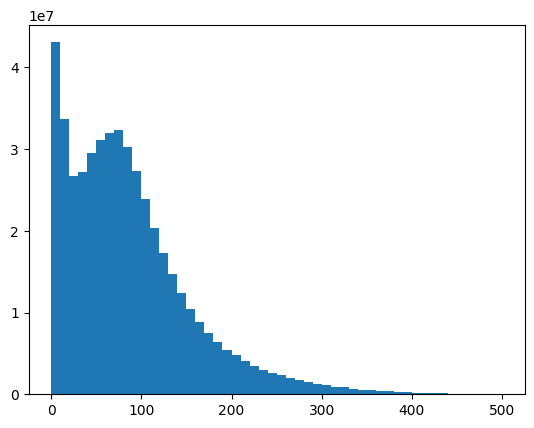

In [116]:
# AGBM_vals = AGBM_vals[AGBM_vals != 0]
plt.hist(AGBM_vals, bins=50, range=[0, 500])
plt.show()